# **Don't Get Kicked!**

![image.png](https://creditkarma-cms.imgix.net/wp-content/uploads/2019/08/how-to-buy-cars-auction_519515713.jpg?fm=webp)

Hello, in this project we will be doing an EDA on [Don't Get Kicked!](https://https://www.kaggle.com/c/DontGetKicked/data) dataset from Kaggle, and then using applied machine learning models to predict or classify if a car purchased at auction is a lemon (not a good purchase, no puns intended).


### **Let's start by installing required libraries**

In [23]:
!pip install scikit-learn xgboost lightgbm plotly graphviz --upgrade --quiet

In [24]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set_style('darkgrid')
matplotlib.rcParams['font.size']= 15
matplotlib.rcParams['figure.figsize']= (10, 5)
matplotlib.rcParams['figure.facecolor']= '#00000000'

In [25]:
!pip install pyarrow --quiet

## **Loading back preprocessed data**

In [26]:
store_dir = './pre_processed_data/'

In [27]:
import joblib

In [28]:
car_auction_preprocessor = joblib.load('car_auction_preprocessor.joblib')

In [29]:
#to read back, use pd.read_parquet()

target_col = car_auction_preprocessor['target_col']

test_split_inputs = pd.read_parquet(store_dir + 'test_split_inputs.parquet')
train_inputs = pd.read_parquet(store_dir + 'train_inputs.parquet')

val_inputs = pd.read_parquet(store_dir + 'val_inputs.parquet')
inputs = pd.read_parquet(store_dir + 'inputs.parquet')

test_split_targets = pd.read_parquet(store_dir + 'test_split_targets.parquet')[target_col]
train_targets = pd.read_parquet(store_dir + 'train_targets.parquet')[target_col]

val_targets = pd.read_parquet(store_dir + 'val_targets.parquet')[target_col]
targets = pd.read_parquet(store_dir + 'targets.parquet')[target_col]

test_inputs = pd.read_parquet(store_dir + 'test_inputs.parquet')

In [30]:
#verifying if data was loaded properly
print('Test_split_inputs:',test_split_inputs.shape)
print('Test_split_targets:',test_split_targets.shape)

print('Train_inputs:',train_inputs.shape)
print('Train_targets:',train_targets.shape)

print('Val_inputs:',val_inputs.shape)
print('Val_targets:',val_targets.shape)

print('Inputs:',inputs.shape)
print('Targets:',targets.shape)

print('Test_inputs:',test_inputs.shape)

Test_split_inputs: (10291, 107)
Test_split_targets: (10291,)
Train_inputs: (52661, 107)
Train_targets: (52661,)
Val_inputs: (10031, 107)
Val_targets: (10031,)
Inputs: (72983, 119)
Targets: (72983,)
Test_inputs: (48707, 119)


# **Predictive Modeling**

## **Note** :
 When trying different machine learning models, we have to select a model which will be good on future data, to achieve this, choose the model which has relatively low bias and low variance.
 
 *Bias* refers to the ability to capture the relationship between features whereas *variance* means how the model performs on the new data or how far predictions it made from actual values, more the difference more the variance.
 
 High Bias means the model is overfitted and high variance means the model is underfitted.
 
 To achieve this we use regularization, boosting and bagging.
 
 Refer for details: https://www.youtube.com/watch?v=EuBBz3bI-aA

## **Baseline Model**

In [31]:
no_counts = targets.value_counts().iloc[1]
yes_counts = targets.value_counts().iloc[0]

avg_no = (no_counts/(no_counts+yes_counts))*100
avg_yes = (yes_counts/(no_counts+yes_counts))*100



print('avg_no',avg_no)
print('avg_yes',avg_yes)

avg_no 12.298754504473644
avg_yes 87.70124549552636


# **Auc-roc curve**

For evaluating classification models we will be using auc-roc curve which is based on recall and precision score.

More Details: https://youtu.be/4jRBRDbJemM



In [32]:
from sklearn.metrics import roc_curve,roc_auc_score

def auc_plot(inputs, targets, preds, pos_label,model,model_name):
  preds = model.predict_proba(inputs)
  fpr, tpr, thres = roc_curve(targets, preds[:,1], pos_label=pos_label)
 

  #curve where fpr=tpr
  random_probs = [0 for i in range(len(targets))]
  p_fpr, p_tpr, _ = roc_curve(targets, random_probs, pos_label=1)

  auc_score = roc_auc_score(targets, preds[:,1])
  
  plt.style.use('seaborn')
  plt.plot(fpr, tpr, '--b', label='LogisticRegression')
  plt.plot(p_fpr, p_tpr, '--g')
  plt.title('ROC Curve')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend([model_name])
  print(model_name,'(AUC Score):',auc_score)
  plt.show();
  

## **Logistic Regression Model**

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
model = LogisticRegression(random_state=42,solver='liblinear').fit(train_inputs, train_targets)

In [35]:
model.classes_

array([0, 1], dtype=int64)

In [36]:
preds = model.predict(train_inputs)

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
accuracy_score(train_targets, preds,)

0.8959001917927878

In [39]:
val_preds = model.predict(val_inputs)

In [40]:
accuracy_score(val_targets, val_preds)

0.8898414913767322

LogisticRegression (AUC Score): 0.7427649424199755


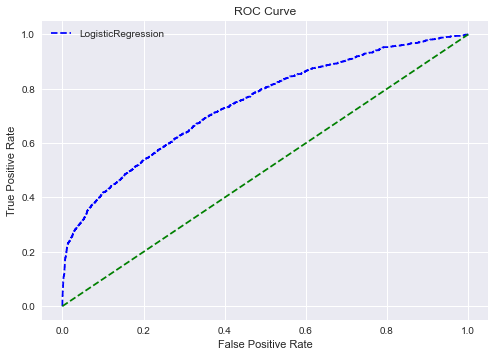

In [41]:
auc_plot(val_inputs,val_targets, val_preds, 1 , model, 'LogisticRegression' )

In [42]:
from sklearn.metrics import confusion_matrix

In [43]:
confusion_matrix(val_targets, val_preds)

array([[8645,  103],
       [1002,  281]], dtype=int64)

In [44]:
val_targets[val_targets == 0].count()

8748

In [45]:
val_targets[val_targets == 1].count()

1283

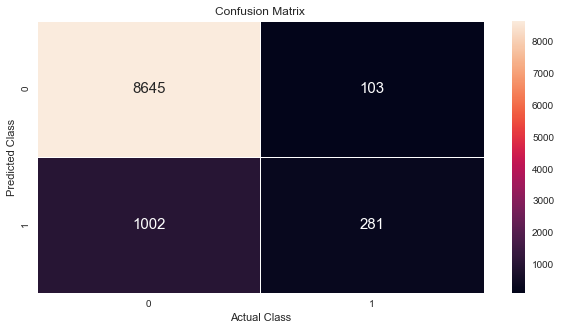

In [46]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(val_targets, val_preds),annot=True,fmt='d',linewidths=.5);
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')
plt.title('Confusion Matrix');


> Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive
> - We can use precision score if the cost associated with false positive is high(model's precision score should be high)


> Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive)
>- We can use recall score if the cost associated with false negative is high(model's recall score should be high)

>Auc score shows the probability of whether the model will be able to distinguish between positive class and negative class.

>To seek a balance between precision and recall we can use f1 score
- Reference: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9


In [47]:
#we can either use expression to calulate recall,precision and f1_score or we can simply use sklearn.metrics to do so.
from sklearn.metrics import recall_score,precision_score,f1_score

In [48]:
from sklearn.metrics import recall_score,precision_score,f1_score
def f1_metric(preds, targets):

  recall = recall_score(preds, targets)
  precision = precision_score(preds, targets)
  f1 = f1_score(preds, targets)

  print('Recall Score:',recall)
  print('Precision Score:',precision)
  print('F1 Score:',f1)

In [49]:
f1_metric(val_targets,val_preds)

Recall Score: 0.2190179267342167
Precision Score: 0.7317708333333334
F1 Score: 0.3371325734853029


For Logistic Regression, the model performs really well with about 89% training accuracy and 88% validation accuracy which is very close to the baseline model accuracy which is 87% accurate if the model simply predicted **yes** and an auc score of about 74% which is fairly good.


# **DecisionTree**

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
model = DecisionTreeClassifier(random_state=42,)

In [52]:
%%time
model.fit(train_inputs, train_targets)

Wall time: 3.01 s


DecisionTreeClassifier(random_state=42)

In [53]:
train_preds = model.predict(train_inputs)

In [54]:
accuracy_score(train_preds, train_targets)

1.0

In [55]:
val_preds = model.predict(val_inputs)

In [56]:
accuracy_score(val_preds, val_targets)

0.8201575117136876

DecisionTree (AUC Score): 0.6039091531800076


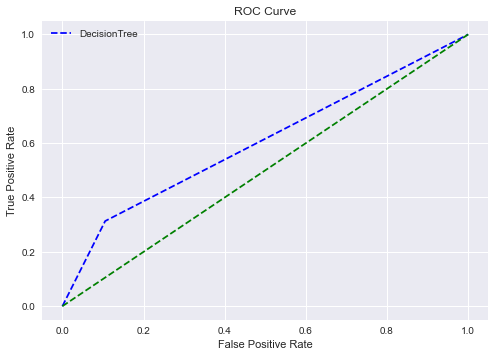

In [57]:
auc_plot(val_inputs, val_targets, val_preds, 1, model, 'DecisionTree')

In [58]:
f1_metric(val_preds, val_targets)

Recall Score: 0.30339622641509434
Precision Score: 0.3133281371784879
F1 Score: 0.30828220858895705


## **Note**


* The Descision Tree model's training accuracy is 100%!! Wow :D....well whenever this happens it's always a good idea to check if targets were inlcuding while training our model mistakenly but that's not the case with the above Descision Tree.

* The above model that we just trained got badly overfit to data as no regulariztion was done, as result it has training accuracy of about 100% but 82% validation accuracy and auc score of about 60%, which is even less than the LogisticRegression model that we trained.





# **Visualizing Decision Tree**

To understand how the CART(Classification And Regression Tree) model has captured the relationship between given features we can visualize it in both graphical or text manner 

In [59]:
from sklearn.tree import plot_tree, export_text

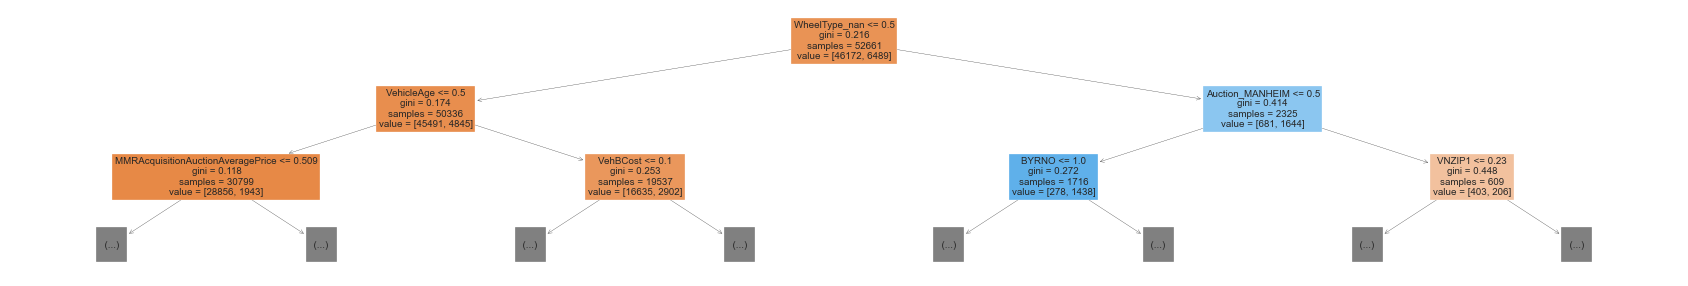

In [60]:
plt.figure(figsize=(30,5))
plot_tree(model, max_depth=2,feature_names=val_inputs.columns, filled=True);

In [61]:
model.tree_.max_depth

40

In [62]:
tree_text = export_text(model, max_depth=10, feature_names=list(val_inputs.columns))
print(tree_text[:2500])

|--- WheelType_nan <= 0.50
|   |--- VehicleAge <= 0.50
|   |   |--- MMRAcquisitionAuctionAveragePrice <= 0.51
|   |   |   |--- VehBCost <= 0.14
|   |   |   |   |--- VehOdo <= 0.52
|   |   |   |   |   |--- PurchaseMonth <= 0.68
|   |   |   |   |   |   |--- VNST_PA <= 0.50
|   |   |   |   |   |   |   |--- MMRCurrentRetailCleanPrice <= 0.28
|   |   |   |   |   |   |   |   |--- MMRCurrentAuctionCleanPrice <= 0.16
|   |   |   |   |   |   |   |   |   |--- Size_MEDIUM <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- VehOdo <= 0.35
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- VehOdo >  0.35
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |--- Size_MEDIUM >  0.50
|   |   |   |   |   |   |   |   |   |   |--- MMRCurrentAuctionCleanPrice <= 0.16
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |  

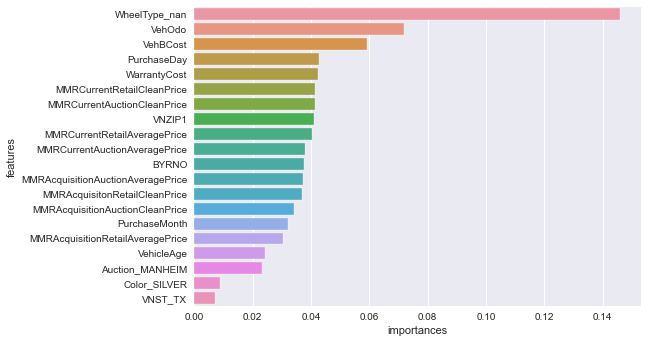

In [63]:
importances_df = pd.DataFrame(
    {
         'features':list(val_inputs.columns),
         'importances':model.feature_importances_,
    }
)

sns.barplot(y='features',x='importances',data=importances_df.sort_values(by='importances',ascending=False).head(20));

# **Random Forest**

A random forest may perform better if the dataset has both categorical and numerical features as it can bag up some features under another feature to form decisions similar to Dscision Trees. 

However in this model many trees are trained with different sets of hyperparameters, and this collection of trees may be called an *forest*. Upon averaging, many of errors are cancelled out hence performing better even without tuning the hyperprameters. Random Forest are based on the concept known as *wisdom of crowd*

For classification problems the most repeated prediction from different trees is taken as final prediciton and in case of regression the final prediction is simply the average of all predictions that the forest has made.

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
model = RandomForestClassifier(n_jobs=-1,random_state=42)

In [66]:
%%time
model.fit(train_inputs,train_targets)

Wall time: 5.52 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [67]:
train_preds = model.predict(train_inputs)

In [68]:
accuracy_score(train_preds, train_targets)

0.9999620212301323

In [69]:
val_preds = model.predict(val_inputs)

In [70]:
accuracy_score(val_preds,val_targets)

0.896221712690659

In [71]:
f1_metric(val_preds, val_targets)

Recall Score: 0.878125
Precision Score: 0.2190179267342167
F1 Score: 0.3505926388022458


RandomForest (AUC Score): 0.7422986962213122


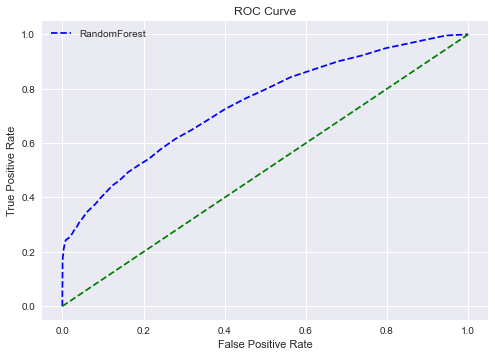

In [72]:
auc_plot(val_inputs,val_targets,val_preds,1,model,'RandomForest')

The overall scores for random forest sky rocket, wisdom of crowd in action and it performs even better on  with 89% validation accuracy as compared to Decision Tree with only 82% but marginally better than Logistic Regression Model with 88% accuracy and an auc score of 74%.

This is great example where we don't always need fancy models, many times even simple models are enough, try to begin solving problems with simple models first then try more advance models and only if there is significant increase in performance then only go with later.

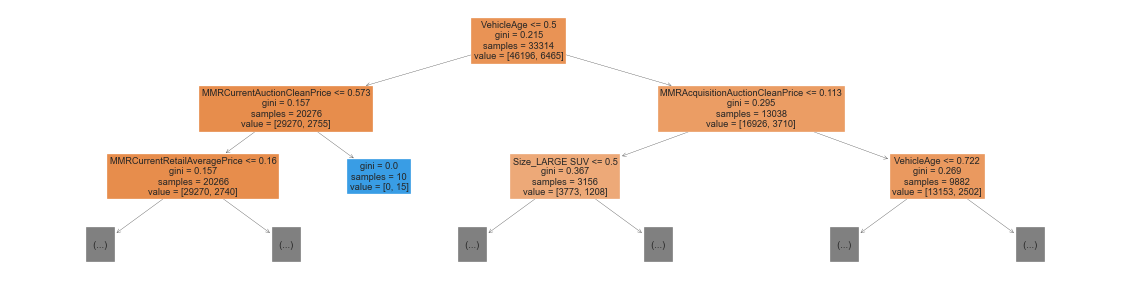

In [73]:
#visualizing random forest model
plt.figure(figsize=(20,5))
plot_tree(model.estimators_[0], max_depth=2,feature_names=val_inputs.columns,filled=True);

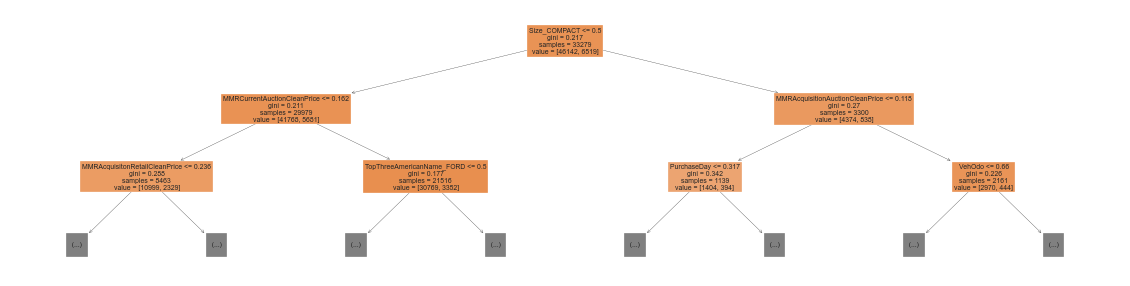

In [74]:
#visualizing a particular estimator 
plt.figure(figsize=(20,5))
plot_tree(model.estimators_[8], max_depth=2,feature_names=val_inputs.columns,filled=True);

In [75]:
len(model.estimators_)

100

In [76]:
importancs_df = pd.DataFrame(
    {
        'features':val_inputs.columns,
        'importances':model.estimators_[0].feature_importances_,
    }
)

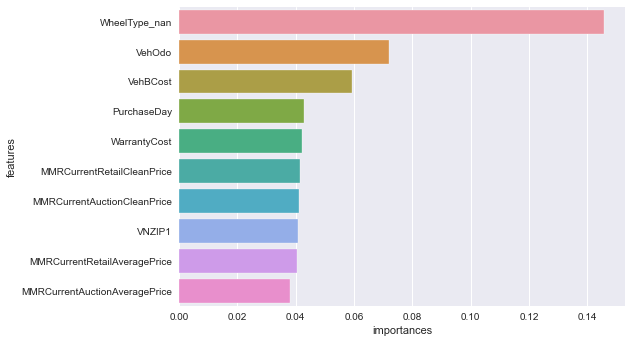

In [77]:
sns.barplot(x='importances',y='features',data=importances_df.sort_values(by='importances',ascending=False).head(10));

# **KFold Cross Validation**
If the dataset we are using is not too large we can do KFold cross validation to make the model more roburst.

In [78]:
from xgboost import XGBClassifier

In [79]:
def train_evaluate(t_inputs, t_targets, v_inputs, v_targets, **params):
  model = XGBClassifier(random_state= 42, n_jobs=-1, **params,use_label_encoder=False,eval_metric='logloss')
  model.fit(t_inputs, t_targets)

  t_preds = model.predict(t_inputs)
  v_preds = model.predict(v_inputs)
  train_score = accuracy_score(t_preds, t_targets)
  val_score = accuracy_score(v_preds, v_targets)

  return train_score, val_score, model

In [80]:
from sklearn.model_selection import KFold

In [81]:
kfold  = KFold(n_splits=5)

In [82]:
 models = []
 for train_indxs, val_indxs in kfold.split(train_inputs):
   X_train, t_targets = train_inputs.iloc[train_indxs], train_targets.iloc[train_indxs]
   X_val, v_targets = train_inputs.iloc[val_indxs], train_targets.iloc[val_indxs]
  
   train_score, val_score, model = train_evaluate(X_train, t_targets, X_val, v_targets, max_depth=4, n_estimators=20) 
   models.append(model)

   print("\nTrain score:",train_score,"Valdation score:",val_score)



Train score: 0.9035795670338017 Valdation score: 0.8968005316623944

Train score: 0.902727337463505 Valdation score: 0.9016331181162173

Train score: 0.902371288186285 Valdation score: 0.9016331181162173

Train score: 0.902228868475397 Valdation score: 0.903057349031523

Train score: 0.9016829262503264 Valdation score: 0.9033421952145841


In [83]:
models

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=20, n_jobs=-1,
               num_parallel_tree=1, predictor='auto', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=

In [84]:
from sklearn.model_selection import cross_val_score

In [85]:
cross_val_scores = cross_val_score(model, train_inputs,train_targets, n_jobs=-1,cv=kfold ) #valdation score using cross_val_score

In [86]:
print('Cross Validation Scores:', cross_val_scores)

Cross Validation Scores: [0.89680053 0.90163312 0.90163312 0.90305735 0.9033422 ]


In [87]:
cross_mean_score = np.mean(cross_val_scores,axis=0)
print("Average Model Validation Accuracy with cross validation:", cross_mean_score)

Average Model Validation Accuracy with cross validation: 0.9012932624281872


In [88]:
model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=10, max_depth=10,use_label_encoder=False,eval_metric='logloss')
model.fit(train_inputs, train_targets)
val_preds = model.predict(val_inputs)
print('\nModel Validation Accuracy without cross validation:',accuracy_score(val_preds, val_targets))


Model Validation Accuracy without cross validation: 0.895324494068388


In [89]:
def predict_avg(inputs):
  return np.mean([model.predict(inputs) for model in models],axis=0)

In [90]:
predict_avg(train_inputs)

array([0., 0., 0., ..., 0., 0., 0.])

In [91]:
print('Number of predictions(No):',len([i for i in predict_avg(val_inputs) if i == 1.0]))
print('Number of predictions(Yes):',len([j for j in predict_avg(val_inputs) if j == 0.]))

Number of predictions(No): 298
Number of predictions(Yes): 9692


# **Hyperparameter Tuning**

## **Tuning Logistic Regression Model**

In [92]:
#func to return training,validation score on given hyperparameter
def get_score(solver='liblinear',**params):
  model = LogisticRegression(random_state=42,solver=solver,**params)
  model.fit(train_inputs,train_targets)
  train_score = accuracy_score(model.predict(train_inputs), train_targets)
  val_score = accuracy_score(model.predict(val_inputs), val_targets)
  return train_score,val_score
  

In [93]:
#func to plot overfitting curve based different given values of a particular hyperparameter
def test_plot(param, values):   
  
  train_scores, val_scores = [], []  
  for value in  values:
    params={ param : value }
    t_score, v_score = get_score(**params)
    train_scores.append(t_score)
    val_scores.append(v_score)

  plt.figure(figsize=(10,5))
  plt.plot(values,train_scores, 'b-o')
  plt.plot(values,val_scores, 's-g') #fmt=[color][marker][line]
  plt.xlabel('Hyperparameter({0})'.format(param))
  plt.ylabel('Train vs Validation Scores')
  plt.title('Overfitting Curve')
  plt.legend(['Trainin Score', 'Validation Score']);
  

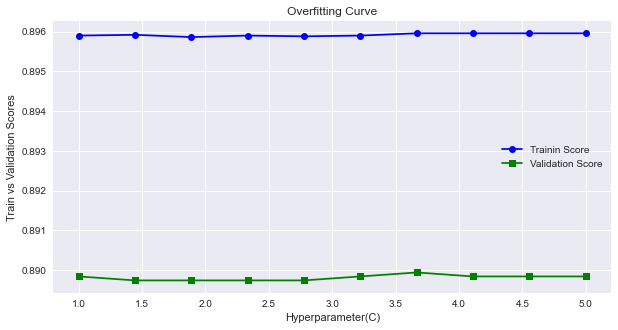

In [94]:
  test_plot('C',np.linspace(1,5,num=10))

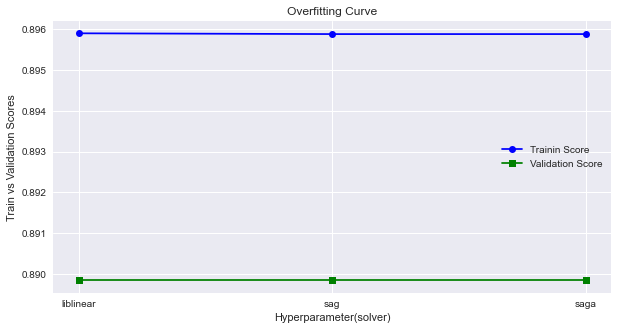

In [95]:
test_plot('solver',['liblinear','sag', 'saga',])

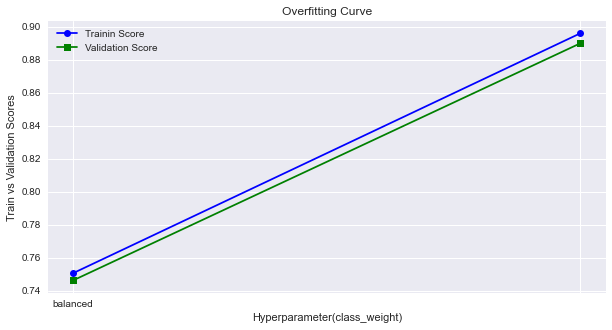

In [96]:
test_plot('class_weight',['balanced',''])

*Note:* We will use grid search and random grid search to find best set of hyperparameters from the search space that we figured out from overfitting curves.

In [97]:
from sklearn.model_selection import GridSearchCV

In [98]:
param_grid = {
    'solver': ['liblinear'],
    'C': np.linspace(3,5,3),
}
lr1 = LogisticRegression()

In [99]:
grid_cv = GridSearchCV(estimator=lr1,param_grid=param_grid,cv=3,n_jobs=-1)
grid_cv.fit(train_inputs,train_targets)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([3., 4., 5.]), 'solver': ['liblinear']})

In [100]:
grid_cv.best_params_

{'C': 4.0, 'solver': 'liblinear'}

In [101]:
grid_cv.best_score_

0.8958052383021081

In [102]:
lr = LogisticRegression(random_state=42, solver='newton-cg', C=3, n_jobs=-1).fit(train_inputs, train_targets)

In [103]:
f1_metric(model.predict(val_inputs), val_targets)

Recall Score: 0.8541033434650456
Precision Score: 0.2190179267342167
F1 Score: 0.34863523573200994


In [104]:
accuracy_score(model.predict(val_inputs), val_targets)

0.895324494068388

In [105]:
accuracy_score(model.predict(train_inputs), train_targets)

0.913484362241507

## **Tuning Decision Tree**

In [106]:
def get_score(solver='liblinear',**params):
  model = DecisionTreeClassifier(random_state=42,**params)
  model.fit(train_inputs,train_targets)
  train_score = accuracy_score(model.predict(train_inputs), train_targets)
  val_score = accuracy_score(model.predict(val_inputs), val_targets)
  return train_score,val_score

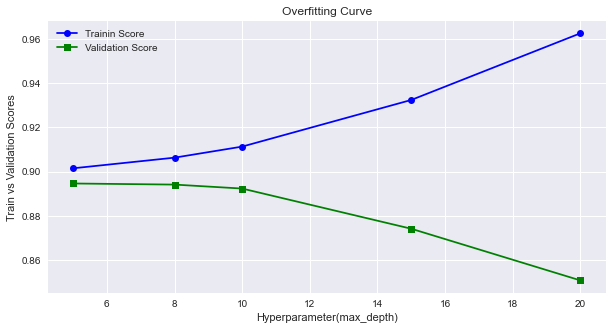

In [107]:
test_plot('max_depth', [5,8,10,15,20,])

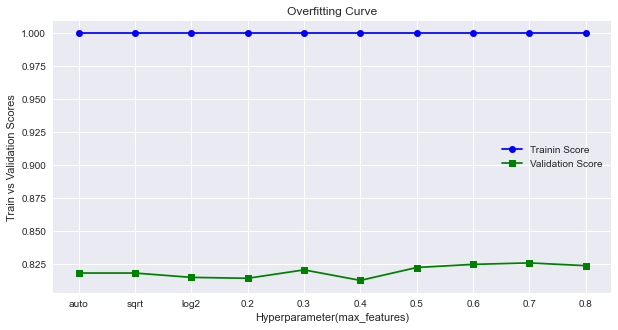

In [108]:
test_plot('max_features', ['auto', 'sqrt', 'log2',0.2,0.3,0.4,0.5,0.6,0.7,0.8])

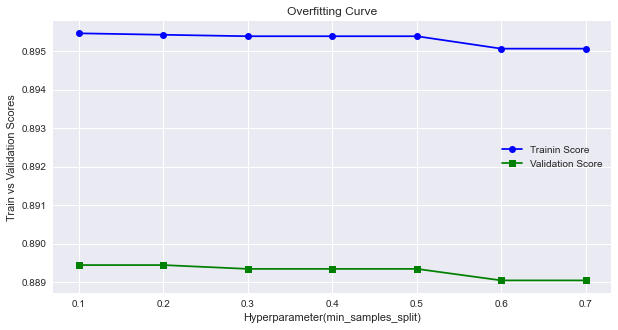

In [109]:
test_plot('min_samples_split',[0.1,0.2,0.3,0.4,0.5,0.6,0.7])

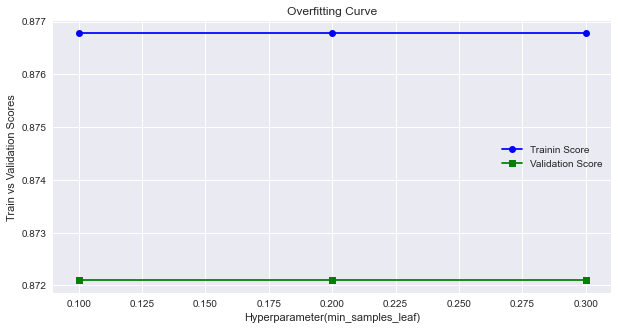

In [110]:
test_plot('min_samples_leaf',[0.1,0.2,0.3])

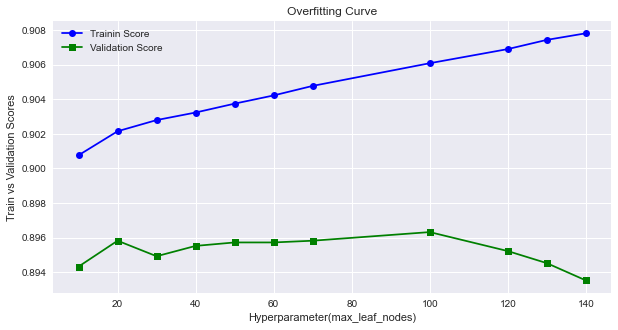

In [111]:
test_plot('max_leaf_nodes',[10,20,30,40,50,60,70,100,120,130,140])

In [112]:
from sklearn.model_selection import RandomizedSearchCV

In [113]:
param_grid = {
    'max_leaf_nodes':[20,30,40,100],
    'min_samples_split':np.linspace(0.5,0.7,num=5),
    # 'max_features':[0.5,0,8],
    'max_depth':np.arange(10,20,5),
}

dt = DecisionTreeClassifier(random_state=42)

In [114]:
random_cv = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,cv=3,n_jobs=-1,random_state=42)

In [115]:
random_cv.fit(train_inputs,train_targets)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([10, 15]),
                                        'max_leaf_nodes': [20, 30, 40, 100],
                                        'min_samples_split': array([0.5 , 0.55, 0.6 , 0.65, 0.7 ])},
                   random_state=42)

In [116]:
random_cv.best_params_

{'min_samples_split': 0.55, 'max_leaf_nodes': 100, 'max_depth': 10}

In [117]:
random_cv.best_score_

0.895292530317579

In [118]:
dt = DecisionTreeClassifier(random_state=42,max_depth= 10, max_leaf_nodes= 100, min_samples_split=0.55).fit(train_inputs,train_targets)

In [119]:
accuracy_score(dt.predict(val_inputs), val_targets)

0.8893430365865816

In [120]:
f1_metric(dt.predict(val_inputs), val_targets)

Recall Score: 0.7064439140811456
Precision Score: 0.23070927513639908
F1 Score: 0.34782608695652173


## **Tuning Random Forest**

In [121]:
def get_score(solver='liblinear',**params):
  model = RandomForestClassifier(random_state=42,**params,n_jobs=-1)
  model.fit(train_inputs,train_targets)
  train_score = accuracy_score(model.predict(train_inputs), train_targets)
  val_score = accuracy_score(model.predict(val_inputs), val_targets)
  return train_score,val_score

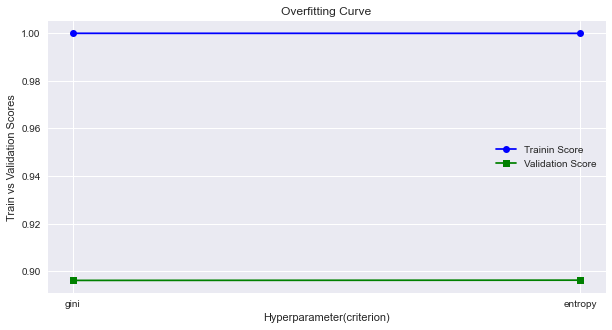

In [122]:
test_plot('criterion',['gini','entropy'])

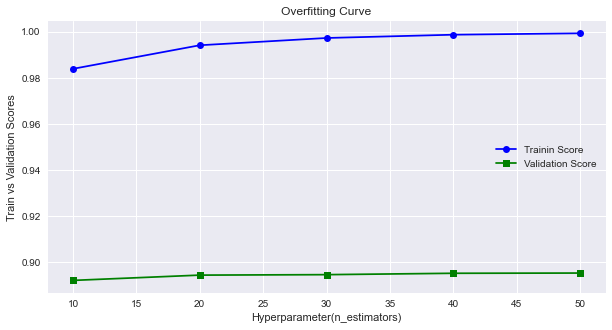

In [123]:
test_plot('n_estimators',[10,20,30,40,50])

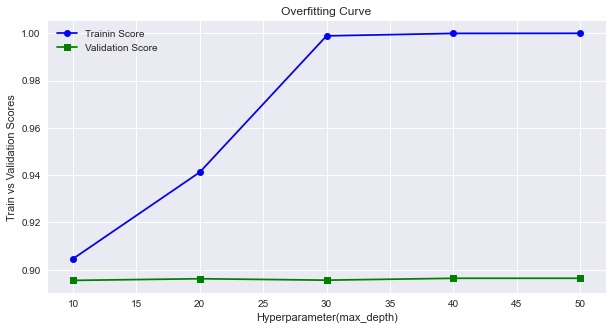

In [124]:
test_plot('max_depth',[10,20,30,40,50])

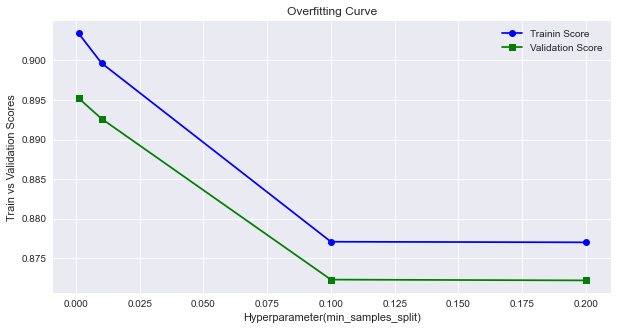

In [125]:
test_plot('min_samples_split',[0.001,0.01,0.1,0.2])

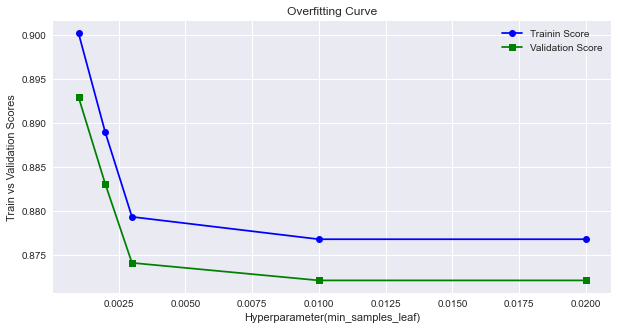

In [126]:
test_plot('min_samples_leaf',[0.001,0.002,0.003,0.01,0.02])

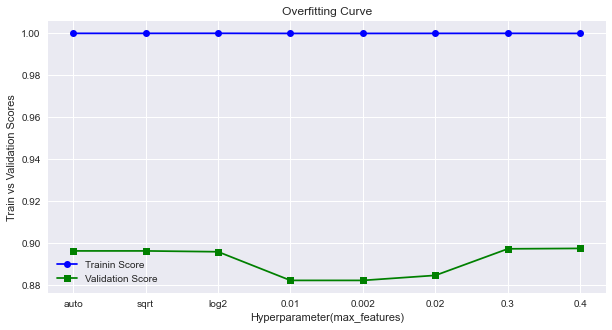

In [127]:
test_plot('max_features',['auto','sqrt','log2',0.01,0.002,0.02,0.3,0.4])

In [128]:
np.arange(10,22,2)

array([10, 12, 14, 16, 18, 20])

In [129]:
np.linspace(0.001,0.01,num=5)

array([0.001  , 0.00325, 0.0055 , 0.00775, 0.01   ])

In [130]:
param_grid = {
     'n_estimators':[40,50],
    'max_depth':np.arange(30,50,10),
    'min_samples_split':np.linspace(0.001,0.01,num=3),
    'min_samples_leaf':np.linspace(0.001,0.01,num=2),
    'max_features':['auto',0.4,0.5],
}

rf = RandomForestClassifier(random_state=42,n_jobs=-1)

In [131]:
param_grid

{'n_estimators': [40, 50],
 'max_depth': array([30, 40]),
 'min_samples_split': array([0.001 , 0.0055, 0.01  ]),
 'min_samples_leaf': array([0.001, 0.01 ]),
 'max_features': ['auto', 0.4, 0.5]}

In [132]:
random_cv = RandomizedSearchCV(estimator=rf,param_distributions=param_grid,cv=3,random_state=42,n_jobs=-1)

In [133]:
random_cv = RandomizedSearchCV(estimator=rf,param_distributions=param_grid,n_jobs=-1)

In [134]:
random_cv = random_cv.fit(train_inputs, train_targets)

In [135]:
random_cv.best_params_

{'n_estimators': 40,
 'min_samples_split': 0.0055000000000000005,
 'min_samples_leaf': 0.001,
 'max_features': 0.4,
 'max_depth': 30}

In [136]:
random_cv.best_score_

0.899242364501504

In [137]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=40,
    max_depth=40,
    min_samples_leaf=0.001,
    min_samples_split=0.001,
    max_features=0.4,
    ).fit(train_inputs,train_targets)

In [138]:
accuracy_score(rf.predict(val_inputs), val_targets)

0.8932309839497558

In [139]:
f1_metric(rf.predict(val_inputs), val_targets)

Recall Score: 0.8251533742331288
Precision Score: 0.20966484801247076
F1 Score: 0.3343691733996271


# **Final Scoring Using Tuned Models on Test Data**

In [140]:
score = accuracy_score(rf.predict(test_split_inputs), test_split_targets)

In [141]:
print('Random Forest Model Accuracy on test data:',score)
f1_metric(rf.predict(test_split_inputs), test_split_targets)

Random Forest Model Accuracy on test data: 0.9032164026819551
Recall Score: 0.7971428571428572
Precision Score: 0.23172757475083056
F1 Score: 0.35907335907335913


In [142]:
score = accuracy_score(lr.predict(test_split_inputs), test_split_targets)

In [143]:
print('Logistic Regression Model Accuracy on test data:',score)
f1_metric(rf.predict(test_split_inputs), test_split_targets)

Logistic Regression Model Accuracy on test data: 0.899426683509863
Recall Score: 0.7971428571428572
Precision Score: 0.23172757475083056
F1 Score: 0.35907335907335913


In [144]:
score = accuracy_score(dt.predict(test_split_inputs), test_split_targets)

In [145]:
print('Decision Tree Model Accuracy on test data:',score)
f1_metric(dt.predict(test_split_inputs), test_split_targets)

Decision Tree Model Accuracy on test data: 0.8990379943640073
Recall Score: 0.6887871853546911
Precision Score: 0.25
F1 Score: 0.3668494820231566


In [146]:
def extract_year(df):
  df['Date'] = pd.to_datetime(df.PurchDate)
  df['PurchaseYear'] = df.Date.dt.year
  df['PurchaseMonth'] = df.Date.dt.month
  df['PurchaseDay'] = df.Date.dt.day
  return df

In [147]:
#car_auction_preprocessor is the joblib file that contain preprocessed data that we already loading in the beginning
def predict_input(model, single_input):
    numeric_cols, encoded_cols = car_auction_preprocessor['numeric_cols'], car_auction_preprocessor['encoded_cols']
    categorical_cols = car_auction_preprocessor['categorical_cols']
    input_df = pd.DataFrame([single_input])
    input_df = extract_year(input_df)
    input_df[numeric_cols] = car_auction_preprocessor['imputer'].transform(input_df[numeric_cols])
    input_df[numeric_cols] = car_auction_preprocessor['scaler'].transform(input_df[numeric_cols])
    input_df[encoded_cols] = car_auction_preprocessor['encoder'].transform(input_df[categorical_cols].values)
    return model.predict(input_df[numeric_cols + encoded_cols])[0]

In [148]:
sample_input = {'AUCGUART': np.nan,
    'Auction': 'ADESA',
    'BYRNO': 1231,
    'Color': 'SILVER',
    'IsBadBuy': 0,
    'IsOnlineSale': 1,
    'MMRAcquisitionAuctionAveragePrice': 4404.0,
    'MMRAcquisitionAuctionCleanPrice': 5357.0,
    'MMRAcquisitionRetailAveragePrice': 7719.0,
    'MMRAcquisitonRetailCleanPrice': 8823.0,
    'MMRCurrentAuctionAveragePrice': 4404.0,
    'MMRCurrentAuctionCleanPrice': 5357.0,
    'MMRCurrentRetailAveragePrice': 7719.0,
    'MMRCurrentRetailCleanPrice': 8823.0,
    'Make': 'CHEVROLET',
    'Model': 'COBALT',
    'Nationality': 'AMERICAN',
    'PRIMEUNIT': np.nan,
    'PurchDate': '1/19/2010',
    'RefId': 949,
    'Size': 'COMPACT',
    'SubModel': '4D SEDAN LS',
    'TopThreeAmericanName': 'GM',
    'Transmission': 'MANUAL',
    'Trim': 'LS',
    'VNST': 'IA',
    'VNZIP1': 50111,
    'VehBCost': 3910.0,
    'VehOdo': 78900,
    'VehYear': 2006,
    'VehicleAge': 4,
    'WarrantyCost': 803,
    'WheelType': 'Covers',
    'WheelTypeID': 2.0
}

In [149]:
predict_input(rf, sample_input)

C:\Users\archa\miniconda3\envs\zerotopandas\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


0

# **Saving the Best Model**

In [150]:
import joblib

car_auction_rf = {
    'model': rf,
    'imputer': car_auction_preprocessor['imputer'],
    'scaler': car_auction_preprocessor['scaler'],
    'encoder': car_auction_preprocessor['encoder'],
    'input_cols': car_auction_preprocessor['input_cols'],
    'target_col': car_auction_preprocessor['target_col'],
    'numeric_cols': car_auction_preprocessor['numeric_cols'],
    'categorical_cols': car_auction_preprocessor['categorical_cols'],
    'encoded_cols': car_auction_preprocessor['encoded_cols']
}

joblib.dump(car_auction_rf, 'car_auction_rf.joblib')

['car_auction_rf.joblib']



 ## **References and Future Work**
>*  Explore more ways to tune hyperparameters like using optuna.
>*   Setting up an ML pipeline.
>*   Gather more information on different kinds of ML models.
>*   Creating more insightful features using feature engineering.
>*   Improve model performance, EDA techniques.







 ## **Resources I found helpful**
>*  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=random%20search#sklearn.model_selection.RandomizedSearchCV
>*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier
>*   https://www.geeksforgeeks.org/how-to-manually-add-a-legend-with-a-color-box-on-a-matplotlib-figure/
>*   https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
>*   https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9








